In [1]:
import os, shutil
path = "./runs/finetune_2023-12-27_13-46-43"
destination_root_folder = "./Santosh/rsna_optim/"
destination = "./Santosh/rsna_optim/models/"
destination1 = "./Santosh/rsna_optim/runs_config"
#iterate through each folder in the path
folder_num = len(os.listdir(path))
for idx, folder in enumerate(sorted(os.listdir(path))):
    if idx == folder_num - 1:
        break

    #get the path of the folder
    folder_path = os.path.join(path, folder)
    if not os.path.exists(os.path.join(destination)):
        os.makedirs(os.path.join(destination))
    
    if not os.path.exists(os.path.join(destination1, f"{idx}")):
        os.makedirs(os.path.join(destination1, f"{idx}"))
    # print(folder_path)
    # #copy file idx.pt to destination folder
    shutil.copy(os.path.join(folder_path, f"best_checkpoint.pth"), os.path.join(destination, f"{idx}.pth"))
    shutil.copy(os.path.join(folder_path, f"LossAccuracy.png"), os.path.join(destination1, f"{idx}", f"LossAccuracy.png"))
    shutil.copy(os.path.join(folder_path, f"train_summary.json"), os.path.join(destination1, f"{idx}", f"train_summary.json"))

shutil.copy(os.path.join(path, f"testresults.csv"), os.path.join(destination_root_folder, f"testresults.csv"))
    
    

'./Santosh/rsna_optim/testresults.csv'

In [6]:
from dataset import DogsCats
# from models.unet import UNet
from engine import trainer
from utils import plot_results
from model import get_model

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision


from torchvision.transforms import v2
torchvision.disable_beta_transforms_warning()

import matplotlib.pyplot as plt
import numpy as np
import random

from utils import EarlyStopper

In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 256

train_transform = v2.Compose([
    # transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        v2.ToTensor(),
        # v2.ToDtype(torch.float32),
        v2.RandomRotation(degrees=(-70, 70)),
        v2.RandomAffine(degrees=(-15, 15), translate=(0.25, 0.25), scale=(0.7, 1.2), shear=(-15, 15, -15, 15)),
        v2.RandomPerspective(distortion_scale=0.2, p=0.2),
        v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.2), antialias=True),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        v2.RandomAutocontrast(p=0.2),
        v2.RandomEqualize(p=0.2),
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])

val_transform = transforms.Compose([
    v2.ToTensor(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),

    ])


trainset = torchvision.datasets.CIFAR10(root='./dataset', transform=train_transform)

testset = torchvision.datasets.CIFAR10(root='./dataset', train=False, transform=val_transform)

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

/home/nuren.zhaksylyk/.conda/envs/CV701_env/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
from utils import load_model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_model("ResNet18", num_classes=10)
model = load_model(model, "runs/finetune_2023-12-13_15-41-32/hparam_2023-12-13_15-41-33/best_model.pt")
model.to(DEVICE)
# torch.compile(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
def val_step(model, test_loader, device):
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_targets = []
    test_f1_predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            m = nn.Softmax(dim=1)            
            predicted = m(outputs)
            # _, predicted = torch.max(outputs.data, 1)
            targets = targets.squeeze().long()
            test_total += targets.size(0)
            _,t = torch.max(outputs.data, 1)
            test_correct += (t == targets).sum().item()
#             print(t)
 
            test_predictions.extend(predicted.cpu().numpy())
            test_f1_predictions.extend(t.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
            # print(test_correct, test_total)
        test_accuracy = 100 * test_correct / test_total
        test_f1 = f1_score(test_targets, test_f1_predictions, average='macro')
        # Print or log validation metrics
        print(f"Test Accuracy: {test_accuracy:.2f}%, F1-Score: {test_f1:.4f}")
        return test_f1, test_accuracy

In [12]:
val_step(model, test_loader, DEVICE)

100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

Test Accuracy: 92.36%, F1-Score: 0.9235


(0.9235376959759597, 92.36)

In [16]:
import pandas as pd
resultsexp = pd.DataFrame(columns=["lr_rate", "num_epochs", "augmentation", "test_acc", "test_loss"])


In [18]:
resultsexp

,lr_rate,num_epochs,augmentation,test_acc,test_loss


In [20]:
resultsexp.loc[len(resultsexp)] = [0.001, 100, "yes", 0.0, 0.0]

In [21]:
resultsexp

,lr_rate,num_epochs,augmentation,test_acc,test_loss
0,0.001,100,yes,0.0,0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

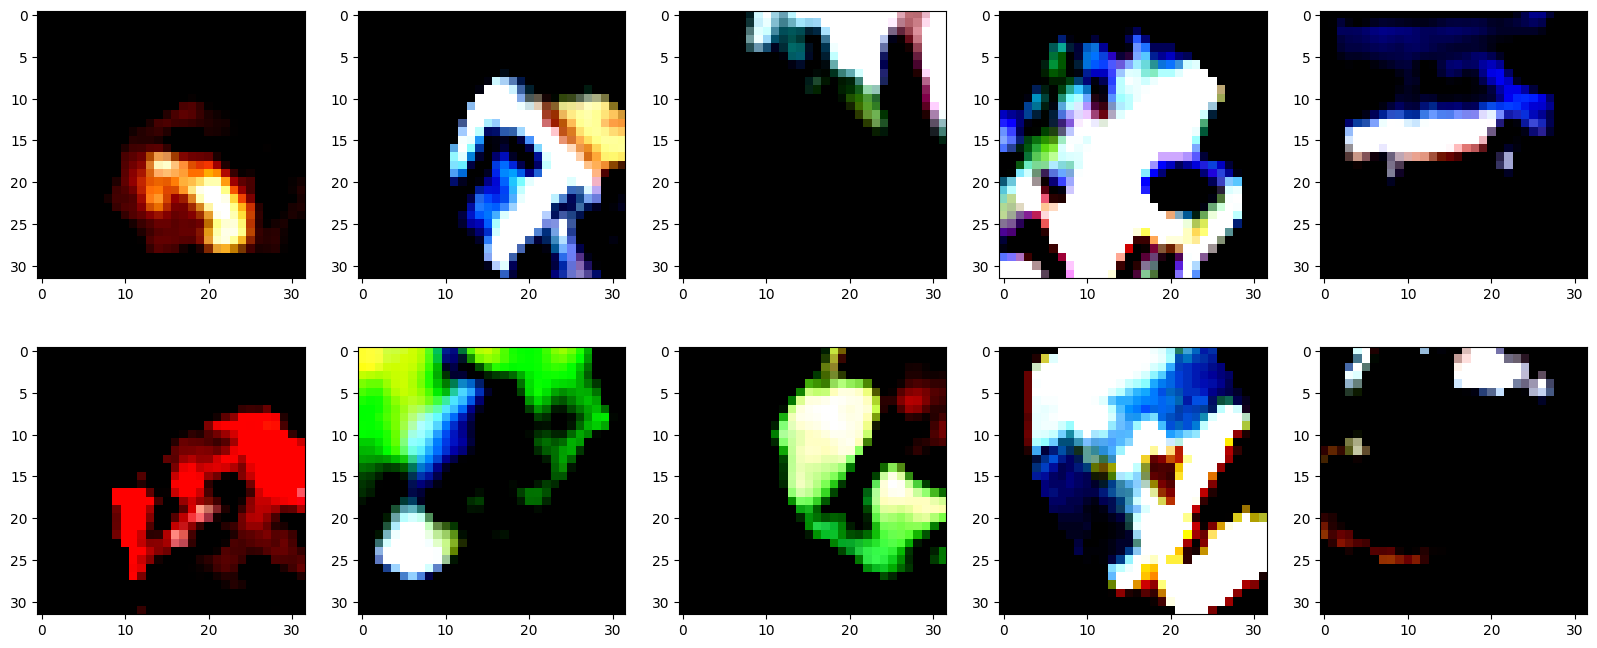

In [76]:
fig = plt.figure(figsize=(20,8))

for i in range(10):
    # idx = torch.randint(len(trainset),(1,)).item()
    img = trainset[i][0]
    img = img.permute(1,2,0)
    fig.add_subplot(2,5,i+1)
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()



In [78]:
model = get_model("ResNet18", False)
model.to("cuda")
from torchsummary import summary

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:

train_dataset = KannadaMNIST(root_dir='dataset/train/')

test_dataset = KannadaMNIST(root_dir='dataset/test/')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)


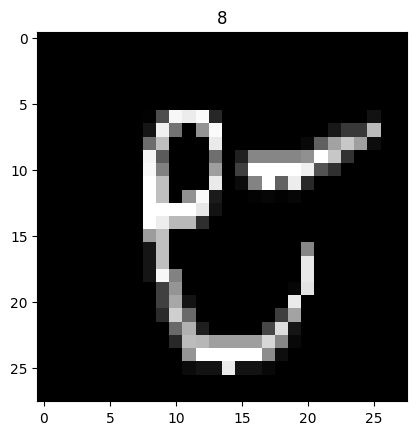

In [8]:
for i, (images, labels) in enumerate(train_loader):
    plt.imshow(images[0].numpy().reshape(28, 28), cmap='gray')
    plt.title(labels[0].item())
    break

In [6]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

In [7]:
model = vgg16()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
for param in model.parameters():
    param.requires_grad = False

for param in model.features[26].parameters():
    param.requires_grad = True

for layer in model.classifier:
    if isinstance(layer, nn.Linear):
        for param in layer.parameters():
            param.requires_grad = True

In [8]:
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights
model = vgg19()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
from torchvision.models import resnet50
model = resnet50()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
model = vgg16()
model.to('cuda')
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [1]:
from torchvision.models import convnext_tiny
from torchvision.models import ConvNeXt_Tiny_Weights

In [3]:
model = convnext_tiny()
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [1]:
from torchvision.models import efficientnet_v2_s
from torchvision.models import EfficientNet_V2_S_Weights

In [2]:
model = efficientnet_v2_s()
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [3]:
from torchsummary import summary

model.to("cuda")

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [ ]:
import os, shutil
path = "./runs/finetune_2023-12-26_21-27-23"
destination = "/l/users/nuren.zhaksylyk/cifar_optim/runs_config"
#iterate through each folder in the path
for idx, folder in enumerate(sorted(os.listdir(path))):

    #get the path of the folder
    folder_path = os.path.join(path, folder)
    # print(folder_path)
    # #copy file idx.pt to destination folder

    #if there is not folder idx in destination folder, create it
    if not os.path.exists(os.path.join(destination, f"{idx}")):
        os.makedirs(os.path.join(destination, f"{idx}"))
    
    shutil.copy(os.path.join(folder_path, f"LossAccuracy.png"), os.path.join(destination, f"{idx}", f"LossAccuracy.png"))
    shutil.copy(os.path.join(folder_path, f"train_summary.json"), os.path.join(destination, f"{idx}", f"train_summary.json"))

    # shutil.copy(os.path.join(folder_path, f"best_model.pt"), os.path.join(destination, f"{idx}.pt"))
    

NotADirectoryError: [Errno 20] Not a directory: './runs/finetune_2023-12-15_17-00-29/testresults.csv/LossAccuracy.png'

In [1]:
import yaml

config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

print(config)

{'LEARNING_RATE': '1e-3', 'LEARNING_SCHEDULER': 'CosineAnnealingLR', 'BATCH_SIZE': 256, 'NUM_EPOCHS': 30, 'LINEAR_PROBING': True, 'PROBING_EPOCHS': 10, 'PATIENCE': 5, 'IMAGE_SIZE': 224, 'MODEL': 'ResNet18', 'PRETRAINED': True, 'LOSS': 'CrossEntropyLoss', 'LR_RATE_LIST': ['2e-5', '1e-5', '3e-6', '1e-6'], 'NUM_EPOCHS_LIST': [15, 20, 25], 'AUGMENT_LIST': ['Minimal', 'Medium', 'Heavy']}


In [3]:
config["test_acc"] = 0.998
config["test_loss"] = 0.111

In [4]:
config

{'LEARNING_RATE': '1e-3',
 'LEARNING_SCHEDULER': 'CosineAnnealingLR',
 'BATCH_SIZE': 256,
 'NUM_EPOCHS': 30,
 'LINEAR_PROBING': True,
 'PROBING_EPOCHS': 10,
 'PATIENCE': 5,
 'IMAGE_SIZE': 224,
 'MODEL': 'ResNet18',
 'PRETRAINED': True,
 'LOSS': 'CrossEntropyLoss',
 'LR_RATE_LIST': ['2e-5', '1e-5', '3e-6', '1e-6'],
 'NUM_EPOCHS_LIST': [15, 20, 25],
 'AUGMENT_LIST': ['Minimal', 'Medium', 'Heavy'],
 'test_acc': 0.998,
 'test_loss': 0.111}

In [6]:
conf = {
    "LEARNING_SCHEDULER": config["LEARNING_SCHEDULER"],
    "BATCH_SIZE": config["BATCH_SIZE"],
    "IMAGE_SIZE": config["IMAGE_SIZE"],
    "MODEL": config["MODEL"],
    "PRETRAINED": config["PRETRAINED"],
    "LOSS": config["LOSS"],
}

In [26]:
a = 0.000001
conf["LEARNING_RATE"] = "{:.1e}".format(a)
conf["NUM_EPOCHS"] = 100
conf["AUGMENTATION"] = "medium"

In [27]:
conf

{'LEARNING_SCHEDULER': 'CosineAnnealingLR',
 'BATCH_SIZE': 256,
 'IMAGE_SIZE': 224,
 'MODEL': 'ResNet18',
 'PRETRAINED': False,
 'LOSS': 'CrossEntropyLoss',
 'LEARNING_RATE': '1.0e-06',
 'NUM_EPOCHS': 100,
 'AUGMENTATION': 'medium'}